### Quick Docker Commands/Set-Up:

docker build -t "name" -f "Dockerfile.txt" .

docker build -t "get_complete" -f "Dockerfile.txt" .  

On local machine:

---
```bash
docker run --entrypoint /bin/bash -it -v /Users/faith/Desktop/Coding:/home/xf2217 get_complete``

docker run -it -p 8888:8888 -v /Users/faith/Desktop/Coding:/home/xf2217  get_complete  jupyter notebook --allow-root --ip 0.0.0.0 --no-browser --NotebookApp.token='' --NotebookApp.password='' --notebook-dir=/home/xf2217
```

---
  
With Meluxina:
### *Solution:*

```bash
module load Python/3.11.3-GCCcore-12.3.0 

#If a package doesn't work.
rm -rf /home/users/u102501/.local/lib/python3.12/site-packages/urllib3*
python -m pip install --upgrade --force-reinstall urllib3
python -c "import urllib3; print(urllib3.__version__)"
```

```bash
module load Apptainer/1.3.1-GCCcore-12.3.0 

apptainer exec --bind /project/home/p200469/get_BIO1018 get_complete_latest.sif python -m jupyter lab --no-browser --ip "*" --NotebookApp.token='' --NotebookApp.password='' --notebook-dir /project/home/p200469/get_BIO1018 --port 8888
```

Split terminal screen:

In local machine:

`ssh -L 8888:localhost:8888 u102501@login.lxp.lu -p 8822 -i ~/.ssh/id_ed25519_mlux`

Enter passphrase,

Then,

`ssh -L 8888:localhost:8888 <mel0000>`  swap <> for your node.

---

### Creating peak_counts.txt File

Retrieve bam and bed files.


```bash
gunzip -c <bed_file> > <bed_file - gz>
samtools index <bam file>
bedtools multicov -bams <bam file> -bed <bed_file> > peak_counts.txt
```

> For RNA retrieve the gene_quantifications.tsv file and continue below.

### Download the necessary files

__Adapting for MCF7__ 

Galaxy:
https://usegalaxy.eu/datasets/4838ba20a6d86765d1685afe6504d674/preview
#Use galaxy to visualize downloaded datasets in a UI friendly environment.

<br>
ENCODE View:

https://www.encodeproject.org/search/?searchTerm=mcf7&type=Dataset  
#Overall MCF7 sample datasets  

https://www.encodeproject.org/reference-epigenomes/ENCSR247DVY/  
#MCF7 Reference - containing multiple bioassays.  

https://www.encodeproject.org/annotations/ENCSR074VNQ/  
#MCF7 cCRE annotation file - checked on Galaxy and is same format to one used in  tutorial.

<br>
Use rsync to transport directory of files to remote server, 
<br>  
<font color="purple"> Example: </font>
<br>
rsync MCF7_IDR_thresholded_peaks.bed meluxina:/project/home/p200469/get_BIO1018/
<br>
rsync peak_counts.txt meluxina:/project/home/p200469/get_BIO1018/  

<br>
<br>  
or,  

<br>

curl directly from the terminal:  
curl -o MCF7_IDR_thresholded_peaks.bed.gz https://www.encodeproject.org/files/ENCFF882OVP/@@download/ENCFF882OVP.bed.gz  
curl -o cCRE_hg38.bed.gz https://www.encodeproject.org/files/ENCFF377XIH/@@download/ENCFF377XIH.bed.gz  

<br>
-O: Saves the file with its original name.  
<br>
-o: Allows you to specify a custom name for the downloaded file.

<br>
<br>

<font color="red"> Error:</font>
using curl causes the file to download as a HTML file rather than a real, valid gzip file.  

<font color='green'> Solution:</font> 
<br>
Use wget instead:  
wget https://www.encodeproject.org/files/ENCFF377XIH/@@download/ENCFF377XIH.bed.gz  
wget https://www.encodeproject.org/files/ENCFF882OVP/@@download/ENCFF882OVP.bed.gz - IDR Threshold Peaks  
wget https://www.encodeproject.org/files/ENCFF607OSL/@@download/ENCFF607OSL.bam - ATAC-Seq BAM File  
  

> Just an example, explore other files to increase size and power of data.

## Start of Code:

In [1]:
#%%
from pathlib import Path

import numpy as np
import snapatac2 as snap
from gcell._settings import get_setting

annotation_dir = get_setting('annotation_dir')
print("gcell currently using annotation directory:", annotation_dir)

gcell currently using annotation directory: /home/users/u102501/.gcell_data/annotations


In [2]:
#cCRE

import pandas as pd
from pyranges import PyRanges as pr

cols = ["Chromosome", "Start", "End", "Name", "Score", "Strand", "SignalValue", "PValue", "QValue", "SummitOffset", "Color", "DNase", "Classification"] 
#Columns variable to change name

#Here I've created a variable called cre which is an object related to the "cCRE_hg38.tsv.gz" file and stands for candidate cis-regulatory elements.
cre = pd.read_csv('cCRE_hg38.bed.gz', sep='\t', header=None, names=cols)
#Pandas which as an open-source Python library used for data manipulation and analysis. It's similar to dplyr on R. It can read and write Excel files
# So cre is the csv file that was downloaded and is read by the "pandas" tool which we made an alias to refer to is as "pd". Similar to R, the separator is noted.

cre = cre[["Chromosome", "Start", "End"]]

cre = pr(cre, int64=True).sort()
#This line converts the cre DataFrame into a PyRanges object with 64-bit integer precision (int64=True).
#Then sorts the genomic intervals in the object by their position (first by Chromosome and then by Start position).

cre.head()
#To view the first few lines of the file.

,Chromosome,Start,End
0,chr1,104896,105048
1,chr1,138866,139134
2,chr1,180743,180904
3,chr1,181014,181237
4,chr1,181289,181639
5,chr1,267925,268171
6,chr1,271226,271468
7,chr1,274329,274481


### Candidate Cis-Regulatory Elements
Candidate cis-regulatory elements are genomic regions identified as having potential regulatory functions, such as enhancers or promoters, that control gene expression. The file being referenced (cCRE_hg38.tsv.gz) likely contains information about these elements for the human genome (hg38 build).

__What Has Been Done so Far?__
1. Read in a cCRE file. (It's in a compressed from and separated by tabs) 
2. Renamed the columns and selected only the first three.
3. Converted the Pandas Dataframe to a Pranges object that is commonly used for genomic data and workflows (e.g., finding overlaps, merging regions). 
4. Then sorted the Pyranges object by Chromosome and then Start position.
5. Viewed first few lines to ensure all looks good.

__Adapting for MCF7__
The pbmc HDF5 dataset contains both gene expression and peak data in the one file.
For the initial stage of my project I will only be incoporating ATAC-Seq data from ENCODE using IDR thresholded peaks (.bed). Thus, some adaptations need to be made to the code.

In [3]:
cols2 = ["Chromosome", "Start", "End", "Name", "Score", "Strand", "SignalValue", "PValue", "QValue", "SummitOffset", "Counts"]
#Columns variable to change name

#peaks = pd.read_csv("MCF7_IDR_thresholded_peaks.bed", sep="\t", header=None, names=cols2)
peaks = pd.read_csv("peak_counts_2.txt", sep="\t", header=None, names=cols2)
#Reading in with Pandas and using cols vector to change column names.

peaks = peaks[["Chromosome", "Start", "End", "Counts"]]
#Selecting only the first four columns

# Convert Start and End to integers
#peaks["Start"] = peaks["Start"].astype(int)
#peaks["End"] = peaks["End"].astype(int)
#I don't think these lines are necessary as it isn't an AnnData object like the tutorial data.

peaks = peaks.drop_duplicates()

peaks = pr(peaks, int64=True).sort()
# Returns the shape (number of rows and columns) of the PyRanges DataFrame

# Display the first few rows
# peaks.head()

print(peaks.df.shape)
print(peaks.head())
#Display number of rows and columns

#This code processes genomic peak data, converting it into a more usable format for analysis.


(69066, 4)
+--------------+-----------+-----------+-----------+
| Chromosome   |     Start |       End |    Counts |
| (category)   |   (int64) |   (int64) |   (int64) |
|--------------+-----------+-----------+-----------|
| chr1         |    196463 |    196690 |        33 |
| chr1         |    778344 |    779188 |       799 |
| chr1         |    804610 |    805040 |        50 |
| chr1         |    826678 |    828112 |      1099 |
| chr1         |    845315 |    846495 |       203 |
| chr1         |    850421 |    850659 |        47 |
| chr1         |    869598 |    870274 |       132 |
| chr1         |    904039 |    904955 |       640 |
+--------------+-----------+-----------+-----------+
Unstranded PyRanges object has 8 rows and 4 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome.


### FuXi Note:
For optimal zero-shot analysis, it is recommended to use a union set of peaks from both the new dataset and the original training peak sets *(i.e. the cre peaks defined above)* to minimize domain shift. However, in this tutorial we will simply perform finetuning using the new peak set from the 10x PBMC multiome data. The union peak set can be constructed as below. 

After that you should re-count the peak count matrix using fragment file, and when write out cell-type specific peaks, ideally remove all non-accessible peaks in each cell types.

---

The BAM file for the MCF7_IDR_thresholded_peaks.bed file should be used to recount the peaks after unionization. For now I will also use the peaks variable alone and come back once all the code is written and passes through.

In [4]:
#peak / cre + cre 
#find all peaks that don't overlap with cre; -> non_overlap_peaks

non_overlap_peaks = peaks.overlap(cre, invert=True)
#invert=True: Ensures that only peaks (from MCF7 file) outside the cre regions are kept. i.e. keeping MCF7 peaks that don't overlap with cre.

#concat with cre and sort
total_peaks = pd.concat([non_overlap_peaks.df, cre.df], ignore_index=True)
#The ignore_index=True parameter in the pd.concat() function tells pandas to re-index the resulting DataFrame after concatenation. 
#Without it, pandas would retain the original indices from the two DataFrames being concatenated, which could result in duplicated indices if the DataFrames have overlapping index values.
#So now this total_peaks variable contains the peaks in MCF7 dataset that don't overlap with cre, and cre. So it is a unique dataset.

total_peaks = pr(total_peaks, int64=True).sort()

#remove chromosome M, Y and those not start with chr
total_peaks = total_peaks.df.query('Chromosome.str.startswith("chr") & ~Chromosome.str.endswith("M") & ~Chromosome.str.endswith("Y") & ~Chromosome.str.startswith("chrUn")')
total_peaks.shape

(1067840, 4)

### What is the Purpose of This?

In this code, cre represents candidate cis-regulatory elements (genomic regions with potential regulatory roles), while peaks represents regions of open chromatin from the experimental data, inferred from ATAC-seq or other assays.

The overlapping is done to identify non-overlapping peaks using:

This step filters peaks that do not overlap with the cCRE regions. The purpose is to isolate peaks not previously annotated as regulatory elements, which may contain novel or unique regions worth further analysis.

So now this total_peaks (or union set) variable contains the peaks in MCF7 dataset that don't overlap with cre, and cre. So it is a unique dataset.

### FuXi Note:
For convenience, we will keep using the peak set called by cellranger here. Note that there is a difference in peak length distribution. However, in general there are no peaks > 1000 bp; and most peaks have a length in order of 10^3 so let's keep using this one. Note that the original training CRE peak set has a unified length of 400 bp.

---

__Adapting for MCF7__
So to adapt this for eventual fine tuning with MCF7, I will use the union set (total_peaks)

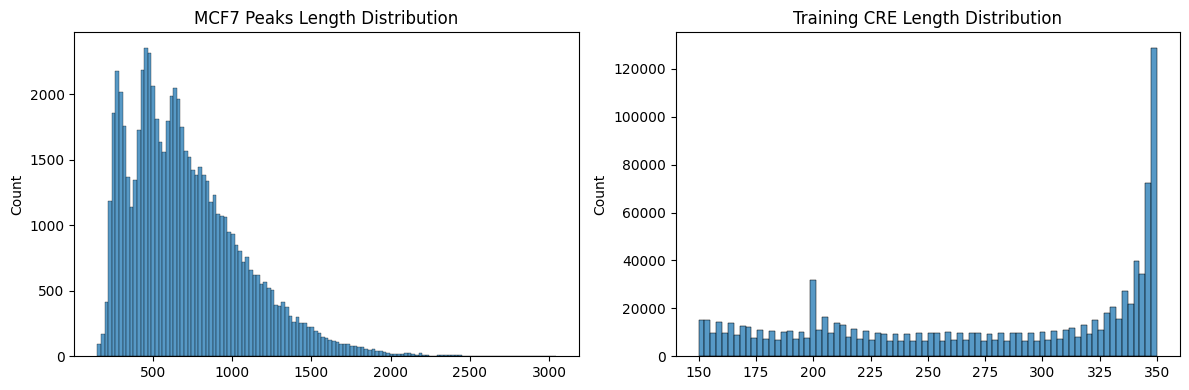

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#plt.subplots(1, 2, figsize=(12, 4)): This creates a figure with two subplots arranged horizontally (1 row, 2 columns).
#The figsize=(12, 4) argument specifies the dimensions of the overall figure in inches (width = 12 inches, height = 4 inches).
#ax1, ax2: These are the axes for the left and right subplots, respectively. 

#sns.histplot(total_peaks.End-total_peaks.Start, ax=ax1)
#Zero-shot analysis, (after pass-through)

sns.histplot(peaks.End-peaks.Start, ax=ax1)
#sns.histplot(peaks.End-peaks.Start, ax=ax1): This plots a histogram of the length of each peak in the peaks DataFrame. 
#The length is calculated by subtracting the Start coordinate from the End coordinate (peaks.End - peaks.Start), which gives the length of each peak region.
#The ax=ax1 argument tells Seaborn to plot this histogram on the left subplot (ax1).

ax1.set_title('MCF7 Peaks Length Distribution')

sns.histplot(cre.End-cre.Start, ax=ax2)  
#sns.histplot(cre.End-cre.Start, ax=ax2): This plots a histogram of the length of each candidate cis-regulatory element (CRE) in the cre DataFrame.
#Similarly, the length is calculated by subtracting the Start coordinate from the End coordinate (cre.End - cre.Start).
#The ax=ax2 argument tells Seaborn to plot this histogram on the right subplot (ax2).

ax2.set_title('Training CRE Length Distribution')

plt.tight_layout()

## Chromosome Assignment
I won' be using RNA-Seq data, so the only thing I need to be focused on is getting the:
Peak accessibility file (.atac.bed) containing:  
Peak coordinates (chr, start, end)  
Normalized accessibility scores (aCPM, 10^5 scale factor) 

Then exporting that into zarr for the next steps. A lot of alteration will be necessary.

### FuXi Note:
We filter for cell types with >100 cells and at least 3M library size.
The selected cell types will be used for training GET models.

_Adapt for chromosomes_

In [6]:
#Adapted:
# Convert PyRanges object to Pandas DataFrame
peaks_df = peaks.df  # Extract the Pandas DataFrame

# Count the number of peaks per chromosome
chromosome_peak_counts = peaks_df.groupby('Chromosome', observed=False).size().to_dict()

# Print message
print("The following chromosomes have more than 100 peaks and a total read count > 3M, adding them to chromosomes_for_modeling:")

# Initialize list to store chromosomes meeting criteria
chromosomes_for_modeling = []

# Loop through each chromosome and its corresponding peak count
for chrom in chromosome_peak_counts:
    # If the chromosome has more than 100 peaks
    if chromosome_peak_counts[chrom] > 100:
        # Calculate "library size" (total Signal_Value for the chromosome)
        libsize = int(peaks_df[peaks_df.Chromosome == chrom]["Counts"].sum())
        
        # If the library size is greater than 1M, add it to the list and print info
        #Had to reduce to 1M for my dataset
        if libsize > 1000000:
            chromosomes_for_modeling.append(chrom)
            print(f"{chrom} number of peaks: {chromosome_peak_counts[chrom]}, library size: {libsize}")


The following chromosomes have more than 100 peaks and a total read count > 3M, adding them to chromosomes_for_modeling:
chr1 number of peaks: 6408, library size: 2899256
chr10 number of peaks: 3242, library size: 1243299
chr11 number of peaks: 3169, library size: 1453403
chr12 number of peaks: 3339, library size: 1487837
chr14 number of peaks: 2655, library size: 1316420
chr15 number of peaks: 2696, library size: 1267117
chr16 number of peaks: 2771, library size: 1517980
chr17 number of peaks: 3577, library size: 2497783
chr19 number of peaks: 2665, library size: 1652126
chr2 number of peaks: 5461, library size: 2100872
chr20 number of peaks: 2702, library size: 1905479
chr3 number of peaks: 4415, library size: 1759621
chr5 number of peaks: 3711, library size: 1555159
chr6 number of peaks: 3847, library size: 1473646
chr7 number of peaks: 3666, library size: 1690212
chr8 number of peaks: 3136, library size: 1516940
chr9 number of peaks: 2913, library size: 1280299


## 2. Export Training Data

### FuXi Note:
For each abundant cell type, we'll generate:

Peak accessibility file (.atac.bed) containing:  
Peak coordinates (chr, start, end)  
Normalized accessibility scores (aCPM, 10^5 scale factor)  

_This will be done later_  
Gene expression file (.rna.csv) containing:  
Gene names  
Normalized expression values (TPM, 10^6 scale factor)

In [7]:
# This should be the same as the peaks variable defined above.

# Import pandas library for data manipulation and pyranges for genomic range operations
import pandas as pd
from pyranges import PyRanges as pr

def get_peak_from_file(file_path: str):
    """
    Reads a peak file and returns a PyRanges object with chromosome positions and read counts.

    Args:
        file_path (str): Path to the peak counts file.

    Returns:
        PyRanges: A PyRanges object with peak data including chromosome, start, end, and counts.
    """
    # Define column names for the file
    cols = ["Chromosome", "Start", "End", "Name", "Score", "Strand", "SignalValue", "PValue", "QValue", "SummitOffset", "Counts"]

    # Read the file
    peaks_df = pd.read_csv(file_path, sep="\t", header=None, names=cols)

    # Ensure numeric columns are properly formatted
    #peaks_df["Start"] = peaks_df["Start"].astype(int)
    #peaks_df["End"] = peaks_df["End"].astype(int)
    #Not necessary.

    peaks_df = peaks_df[["Chromosome", "Start", "End", "Counts"]]

    peaks_df = peaks_df.drop_duplicates()

    # Convert to PyRanges for efficient genomic operations
    peaks = pr(peaks_df)

    return peaks

# Example usage
peaks = get_peak_from_file("peak_counts_2.txt")

# Display the shape of the DataFrame
print(peaks.df.shape)  # Output (rows, columns)

(69066, 4)


In [8]:
import numpy as np
import pandas as pd
from pyranges import PyRanges as pr

def get_peak_acpm_for_chromosome(file_path: str):
    """
    Calculate the aCPM (normalized counts) for each chromosome.

    Args:
        file_path (str): Path to the peak counts file.

    Returns:
        pd.DataFrame: DataFrame containing peaks with aCPM values.
    """
    # Read the peak counts file
    peaks = get_peak_from_file(file_path).df  # Using our previous function

    # Get total counts per peak
    counts = np.array(peaks["Counts"]).flatten()

    # Compute aCPM (adjusted counts per million) using log10 transformation
    acpm = np.log10(counts / counts.sum() * 1e5 + 1)

    # Normalize the aCPM values so that the maximum value is 1
    peaks["aCPM"] = acpm / acpm.max()

    # Filter out unwanted chromosomes (e.g., Mitochondrial, Y, and 'chrUn' entries)
    peaks = peaks.query('Chromosome.str.startswith("chr") & ~Chromosome.str.endswith("M") & ~Chromosome.str.endswith("Y") & ~Chromosome.str.startswith("chrUn")')

    # Convert back to PyRanges for efficiency, then sort and return as a DataFrame
    return pr(peaks, int64=True).sort().df

# Example usage
acpm_peaks = get_peak_acpm_for_chromosome("peak_counts_2.txt")

# Display first few rows
print(acpm_peaks.head())

  Chromosome   Start     End  Counts      aCPM
0       chr1  196463  196690      33  0.020576
1       chr1  778344  779188     799  0.261196
2       chr1  804610  805040      50  0.030428
3       chr1  826678  828112    1099  0.310559
4       chr1  845315  846495     203  0.102779


### FuXi Note:
Let's run the function above to save the peak with aCPM for all cell types (chromsomes for me). Note that here we use the common peak set for all cell types. Later in the dataset we will be able to filter out peaks with no accessibility for each cell type.

✅ All chromosomes saved to all_chromosomes.atac.bed


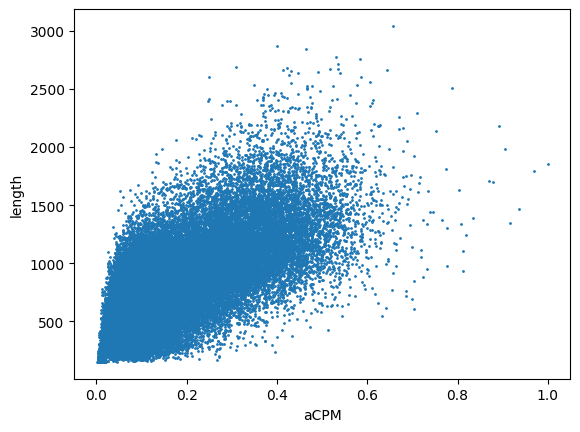

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyranges import PyRanges as pr

def save_acpm(file_path: str, output_file: str) -> pd.DataFrame:
    """
    Computes and saves aCPM (adjusted counts per million) for all chromosomes into a single file.

    Args:
        file_path (str): Path to the peak counts file.
        output_file (str): Path to save the final merged output.

    Returns:
        pd.DataFrame: Processed peaks DataFrame with 'Chromosome', 'Start', 'End', and 'aCPM'.
    """
    # Compute aCPM for all peaks
    peaks = get_peak_acpm_for_chromosome(file_path)

    # Drop duplicate rows (if any)
    peaks = peaks.drop_duplicates()

    # Keep only relevant columns
    peaks = peaks[["Chromosome", "Start", "End", "aCPM"]]

    # Ensure proper sorting
    peaks = peaks.sort_values(by=["Chromosome", "Start", "End"])

    # ✅ Save everything to **one** merged file instead of per chromosome
    peaks.to_csv(output_file, sep='\t', index=False, header=False)

    print(f"✅ All chromosomes saved to {output_file}")

    return peaks  # Return the modified DataFrame

# Run processing and save as a single file
output_file = "all_chromosomes.atac.bed"
processed_peaks = save_acpm("peak_counts_2.txt", output_file)

# ✅ Fix: Compute 'length' **BEFORE** plotting
processed_peaks["length"] = processed_peaks["End"] - processed_peaks["Start"]

# ✅ Fix: Use `processed_peaks` for the plot
processed_peaks.plot(y='length', x='aCPM', kind='scatter', s=1)

# ✅ Ensure the plot actually displays
plt.show()

In [11]:
peaks = processed_peaks
peaks

,Chromosome,Start,End,aCPM,length
0,chr1,196463,196690,0.020576,227
1,chr1,778344,779188,0.261196,844
2,chr1,804610,805040,0.030428,430
3,chr1,826678,828112,0.310559,1434
4,chr1,845315,846495,0.102779,1180
...,...,...,...,...,...
69058,chrX,155819808,155820788,0.077330,980
69059,chrX,155880949,155881955,0.301123,1006
69060,chrX,155966905,155967397,0.063328,492
69061,chrX,156013630,156013912,0.084428,282


> This is the second interation of this code, intended to expand previosuly created files. Thus, I will be concatenating this output with a previous output. Skip this step if it's your first time running the code.

In [10]:
import pandas as pd

# Load both files
file1 = "all_chromosomes.atac.bed"
file2 = "all_chromosomes_1.atac.bed"

# Read the files into pandas DataFrames
df1 = pd.read_csv(file1, sep='\t', header=None, names=["Chromosome", "Start", "End", "aCPM"])
df2 = pd.read_csv(file2, sep='\t', header=None, names=["Chromosome", "Start", "End", "aCPM"])

# Merge the two DataFrames
merged_df = pd.concat([df1, df2])

# Ensure proper sorting
merged_df = merged_df.sort_values(by=["Chromosome", "Start", "End"])

merged_df = merged_df.drop_duplicates()

# Save the merged file
output_file = "all_chromosomes_merged.atac.bed"
merged_df.to_csv(output_file, sep='\t', index=False, header=False)

print(f"Merged file saved as {output_file}")

Merged file saved as all_chromosomes_merged.atac.bed


In [12]:
print(merged_df.shape)

(135914, 4)


### FuXi Note:
Now let's save the RNA csv files.

_This will be done later_  
Gene expression file (.rna.csv) containing:  
Gene names  
Normalized expression values (TPM, 10^6 scale factor)

First need to map gene_quantifications.tsv file to chromsomes using Homo_sapiens.gene_info from: https://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz

### 📝 Step 1: Extract Ensembl Gene IDs (Without Version Numbers)
The gene_id column in your gene_quantifications.tsv contains Ensembl IDs with version numbers. We need to strip the version numbers to match the format in the GTF file.

In [14]:
import pandas as pd

# Define column names for gene quantifications file
quant_cols = [
    "gene_id", "transcript_id(s)", "length", "effective_length", "expected_count", "TPM",
    "FPKM", "posterior_mean_count", "posterior_standard_deviation_of_count",
    "pme_TPM", "pme_FPKM", "TPM_ci_lower_bound", "TPM_ci_upper_bound",
    "TPM_coefficient_of_quartile_variation", "FPKM_ci_lower_bound",
    "FPKM_ci_upper_bound", "FPKM_coefficient_of_quartile_variation"
]

#Contains reduced columns which is the case for some tsv files.
quant_cols_2 = [
    "gene_id", "transcript_id(s)", "length", "effective_length", "expected_count", "TPM",
    "FPKM", "posterior_mean_count", "posterior_standard_deviation_of_count",
    "pme_TPM", "pme_FPKM", "TPM_ci_lower_bound", "TPM_ci_upper_bound",
    "FPKM_ci_lower_bound", "FPKM_ci_upper_bound"
]

# Load gene quantifications file
gene_quant = pd.read_csv("gene_quantifications_2.tsv", sep="\t", header=0, names=quant_cols_2, dtype={"gene_id": str})

# Keep only rows where gene_id starts with 'ENSG' (filter for Ensembl IDs)
gene_quant_ensembl = gene_quant[gene_quant["gene_id"].str.startswith("ENSG", na=False)].copy()

# Remove version numbers from Ensembl Gene IDs
gene_quant_ensembl["gene_id"] = gene_quant_ensembl["gene_id"].str.split(".").str[0]

# Calculate normalized counts (TPM-like)
counts = gene_quant_ensembl["expected_count"]
normalized_counts = np.log10(counts / counts.sum() * 1e6 + 1)

# Apply log10 transformation (similar to the tutorial)
gene_quant_ensembl["TPM"] = normalized_counts

# Save the cleaned Ensembl-only file with recalculated TPM values
gene_quant_ensembl.to_csv("gene_quantifications_ensembl_only.tsv", sep="\t", index=False)

print(f"Gene quantifications file with recalculated and log-transformed TPM values saved.")
print(gene_quant_ensembl.head())

Gene quantifications file with recalculated and log-transformed TPM values saved.
             gene_id                                   transcript_id(s)  \
649  ENSG00000000003  ENST00000373020.8,ENST00000494424.1,ENST000004...   
650  ENSG00000000005                ENST00000373031.4,ENST00000485971.1   
651  ENSG00000000419  ENST00000371582.8,ENST00000371584.8,ENST000003...   
652  ENSG00000000457  ENST00000367770.5,ENST00000367771.10,ENST00000...   
653  ENSG00000000460  ENST00000286031.10,ENST00000359326.8,ENST00000...   

      length  effective_length  expected_count       TPM   FPKM  \
649  2145.21           1967.00           115.0  0.870713   3.21   
650   940.50            762.35             0.0  0.000000   0.00   
651  1082.55            904.34          1429.0  1.907632  86.63   
652  5059.78           4881.56           403.0  1.371371   4.53   
653  2692.04           2513.83           390.0  1.357746   8.51   

     posterior_mean_count  posterior_standard_deviation_of_count

### 📝 Step 2: Process GTF File to Extract Ensembl IDs
The GTF file (Homo_sapiens.GRCh38.113.gtf) contains Ensembl Gene IDs without version numbers, so we need to extract:

Chromosome  
Gene ID (Ensembl)  
Gene Name  

In [15]:
def process_gtf(gtf_file: str, output_file: str):
    """
    Extracts Ensembl gene_id, gene_name, and chromosome from a GTF file.
    Removes version numbers from gene_id.

    Args:
        gtf_file (str): Path to the **uncompressed** GTF file.
        output_file (str): Path to save the cleaned file.
    """
    data = []

    # Open uncompressed GTF
    with open(gtf_file, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue  # Skip header lines
            
            fields = line.strip().split("\t")
            
            # Ensure it's a gene entry
            if fields[2] == "gene":
                chrom = fields[0]  # Chromosome
                attributes = fields[8]  # Metadata

                # Extract gene_id and gene_name
                gene_id = None
                gene_name = None
                for attr in attributes.split(";"):
                    attr = attr.strip()
                    if attr.startswith("gene_id"):
                        gene_id = attr.split('"')[1].split(".")[0]  # Strip version (e.g., ENSG00000187634.14 → ENSG00000187634)
                    elif attr.startswith("gene_name"):
                        gene_name = attr.split('"')[1]  # Extract name

                if gene_id and gene_name:
                    data.append([chrom, gene_id, gene_name])

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["Chromosome", "Gene_ID", "Gene_Name"])

    # Normalize chromosome names (e.g., '1' -> 'chr1')
    df["Chromosome"] = df["Chromosome"].apply(lambda x: f"chr{x}" if not x.startswith("chr") else x)

    # Save as a clean TSV
    df.to_csv(output_file, sep="\t", index=False)

    print(f"Processed GTF file saved to: {output_file}")

# Example Usage
process_gtf("Homo_sapiens.GRCh38.113.gtf", "processed_gene_annotations.tsv")

Processed GTF file saved to: processed_gene_annotations.tsv


### 📝 Step 3: Merge Gene Quantifications with GTF Metadata
Now that we have:

- gene_quantifications_ensembl_only.tsv (gene expression data with Ensembl IDs only)
- processed_gene_annotations.tsv (GTF metadata with Chromosome and Gene Name)  
We can merge them based on gene_id.

In [16]:
# Load cleaned GTF metadata
gtf_metadata = pd.read_csv("processed_gene_annotations.tsv", sep="\t")

# Load cleaned Ensembl-only gene quantifications file
gene_quant_ensembl = pd.read_csv("gene_quantifications_ensembl_only.tsv", sep="\t")

# Merge gene quantifications with chromosome and gene name information
merged_df = gene_quant_ensembl.merge(gtf_metadata, left_on="gene_id", right_on="Gene_ID", how="left")

# Keep only relevant columns: Chromosome, Gene_Name, TPM
merged_df = merged_df[["Chromosome", "Gene_Name", "TPM"]]

# Drop NaN values (i.e., genes that didn't have chromosome mapping)
merged_df = merged_df.dropna()

# Save merged file
merged_df.to_csv("gene_quantifications_with_chromosomes.tsv", sep="\t", index=False)

print(f"Final gene quantifications file saved with Chromosome, Gene_Name, and TPM.")

Final gene quantifications file saved with Chromosome, Gene_Name, and TPM.


In [17]:
import re
import pandas as pd

# Define a list of standard chromosomes (chr1-22, chrX, chrY, chrM)
standard_chromosomes = {f"chr{i}" for i in range(1, 23)}.union({"chrX", "chrY", "chrM"})

# Filter out non-standard chromosomes
merged_df = merged_df[merged_df["Chromosome"].isin(standard_chromosomes)]

# Save all TPM values for all valid chromosomes into one file
merged_df.to_csv("all_chromosomes.rna.csv", index=False)

print(f"All TPM values saved in 'all_chromosomes.rna.csv', excluding alternative contigs.")

All TPM values saved in 'all_chromosomes.rna.csv', excluding alternative contigs.


In [18]:
print(merged_df.shape)
print(merged_df.head())

(41352, 3)
  Chromosome Gene_Name       TPM
0       chrX    TSPAN6  0.870713
1       chrX      TNMD  0.000000
2      chr20      DPM1  1.907632
3       chr1     SCYL3  1.371371
4       chr1     FIRRM  1.357746


Now to load in Entrez Gene Info too

### 🔹 Step 1: Load & Process Entrez Gene Info
The Homo_sapiens.gene_info file contains GeneID (Entrez ID), Symbol, and Chromosome.

In [19]:
import pandas as pd
import numpy as np

# Load gene quantifications file again to extract Entrez IDs
gene_quant = pd.read_csv("gene_quantifications_2.tsv", sep="\t", dtype={"gene_id": str})

# Keep only rows where gene_id does NOT start with 'ENSG' (these are Entrez IDs)
gene_quant_entrez = gene_quant[~gene_quant["gene_id"].str.startswith("ENSG", na=False)].copy()

# Load the Entrez metadata file
entrez_metadata = pd.read_csv("Homo_sapiens.gene_info", sep="\t", dtype=str)

# Keep only relevant columns and rename them
entrez_metadata = entrez_metadata[["GeneID", "Symbol", "chromosome"]].rename(columns={
    "GeneID": "gene_id",  # Match column names for merging
    "Symbol": "gene_name",
    "chromosome": "Chromosome"
})

# Convert gene_id to string for safe merging
gene_quant_entrez["gene_id"] = gene_quant_entrez["gene_id"].astype(str)
entrez_metadata["gene_id"] = entrez_metadata["gene_id"].astype(str)

# Merge Entrez gene quantifications with gene names & chromosome info
merged_entrez = gene_quant_entrez.merge(entrez_metadata, on="gene_id", how="left")

# Keep only necessary columns
merged_entrez = merged_entrez[["Chromosome", "gene_name", "expected_count"]].dropna(subset=["Chromosome"])

# Normalize expected counts to TPM-like values and apply log10 transformation
counts = merged_entrez["expected_count"]
merged_entrez["TPM"] = np.log10(counts / counts.sum() * 1e6 + 1)

# Save processed and normalized Entrez-mapped data
merged_entrez = merged_entrez[["Chromosome", "gene_name", "TPM"]]  # Keep only relevant columns
merged_entrez.to_csv("gene_quantifications_entrez.tsv", sep="\t", index=False)

print(f"Processed and log-transformed Entrez gene quantifications saved. Rows: {merged_entrez.shape[0]}")

Processed and log-transformed Entrez gene quantifications saved. Rows: 69


### 🔹 Step 2: Merge Entrez IDs with Existing Data
Now we will merge the Entrez IDs into the processed gene quantifications file.

&

### 🔹 Step 3: Save TPM Values per Chromosome (Including Entrez IDs)
Now that we have both Ensembl & Entrez genes mapped, let's save the TPM values per chromosome.

In [20]:
# Load Ensembl-processed file
merged_ensembl = pd.read_csv("gene_quantifications_with_chromosomes.tsv", sep="\t")

# Load Entrez-processed file
merged_entrez = pd.read_csv("gene_quantifications_entrez.tsv", sep="\t")

# **Append Entrez rows to Ensembl dataset**
final_merged = pd.concat([merged_ensembl, merged_entrez], ignore_index=True)

# Save the final merged dataset
final_merged.to_csv("final_gene_quantifications.tsv", sep="\t", index=False)

print(f"Final gene quantifications file saved. Total rows: {final_merged.shape[0]}")

Final gene quantifications file saved. Total rows: 41476


In [21]:
import pandas as pd

# Load final processed dataset
final_df = pd.read_csv("final_gene_quantifications.tsv", sep="\t")

# Drop duplicate 'gene_name' column if it exists
if "gene_name" in final_df.columns and "Gene_Name" in final_df.columns:
    final_df = final_df.drop(columns=["gene_name"])

# Rename `Gene_Name` to `gene_name`
final_df = final_df.rename(columns={"Gene_Name": "gene_name"})

# Check if rename worked
print(final_df.columns)  # Confirm only one 'gene_name' column exists

# Standard chromosomes
standard_chromosomes = {f"chr{i}" for i in range(1, 23)}.union({"chrX", "chrY", "chrM"})

# Filter out non-standard chromosomes
filtered_df = final_df[final_df["Chromosome"].isin(standard_chromosomes)]
print(f"Rows remaining after filtering: {filtered_df.shape[0]}")

# Ensure `gene_name` exists before processing
print(filtered_df.head())

# Use lowercase 'gene_name' and select relevant columns
final_output = filtered_df[["gene_name", "TPM"]]

# Save all chromosomes into one file
final_output.to_csv("all_chromosomes.rna.csv", index=False)

print(f"Total rows saved: {final_output.shape[0]}")

Index(['Chromosome', 'gene_name', 'TPM'], dtype='object')
Rows remaining after filtering: 41352
  Chromosome gene_name       TPM
0       chrX    TSPAN6  0.870713
1       chrX      TNMD  0.000000
2      chr20      DPM1  1.907632
3       chr1     SCYL3  1.371371
4       chr1     FIRRM  1.357746
Total rows saved: 41352


> Merging RNA CSV files but averaging TPM values as they contain the same genes and I don't want duplicates. Skip if this is your first time running this code.

In [30]:
import pandas as pd

# Load both datasets
file3 = "all_chromosomes.rna.csv"
file4 = "all_chromosomes_1.rna.csv"

# Read the files into pandas DataFrames
df1 = pd.read_csv(file3)
df2 = pd.read_csv(file4)

# Merge and calculate the average TPM for common genes
merged_df = pd.concat([df1, df2]).groupby("gene_name", as_index=False).mean()

# Save the merged DataFrame
output_file = "all_chromosomes_merged.rna.csv"
merged_df.to_csv(output_file, index=False)

# Print confirmation
print(f"Merged file saved as {output_file}")
print(merged_df.head())

Merged file saved as all_chromosomes_merged.rna.csv
   gene_name       TPM
0    5S_rRNA  0.000000
1  5_8S_rRNA  0.070325
2        7SK  0.397729
3       A1BG  0.327853
4   A1BG-AS1  0.930319


In [31]:
print(merged_df.shape)

(40905, 2)


## 3. Query motifs and save data as zarr files.

In [30]:
# NOTE: tabix has to be >= 1.17
! tabix --version

tabix (htslib) 1.21
Copyright (C) 2024 Genome Research Ltd.


In [32]:
# Import the necessary libraries and modules
import os
from pathlib import Path

# Import specific functions from the 'gcell._settings' module and 'preprocess_utils' module
from gcell._settings import get_setting
from preprocess_utils import (
    add_atpm,        # Function to add ATPM (likely a type of data or calculation)
    add_exp,         # Function to add expression data
    create_peak_motif,  # Function to create peak motif data
    download_motif,     # Function to download motif data
    get_motif,          # Function to retrieve motif data
    query_motif,        # Function to query motif data
)

# Get the annotation directory setting using the 'get_setting' function and convert it to a Path object
annotation_dir = Path(get_setting('annotation_dir'))

# Print the directory being used for annotations (retrieved from the configuration)
print("gcell currently using annotation directory:", annotation_dir)

gcell currently using annotation directory: /home/users/u102501/.gcell_data/annotations


### Download motif bed file

In [33]:
motif_bed_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz"
motif_bed_index_url = "https://resources.altius.org/~jvierstra/projects/motif-clustering/releases/v1.0/hg38.archetype_motifs.v1.0.bed.gz.tbi"


if (
    motif_bed_url
    and motif_bed_index_url
    and not (
        (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz").exists()
        or (annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz.tbi").exists()
    )
):
    download_motif(motif_bed_url, motif_bed_index_url, motif_dir=annotation_dir)
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")
else:
    motif_bed = str(annotation_dir / "hg38.archetype_motifs.v1.0.bed.gz")

### Query Motif

In [34]:
peak_bed = "all_chromosomes_merged.atac.bed"  # Assuming peak files are named per chromosome

if os.path.exists(peak_bed):  # Ensure the peak file exists
        # Query motif file for the current chromosome's peak file
        peaks_motif = query_motif(peak_bed, motif_bed)

        # Process the queried motif data
        motif_output = get_motif(peak_bed, peaks_motif)

Peak motif extraction completed. Results saved in get_motif.bed


## 4. Create Peak Motif .Zarr File

Create a peak x motif matrix stored in a zarr file. If you are working on multiple cell types with the same peak set, you can use the same peak bed and zarr file for all cell types.


In [35]:
create_peak_motif("get_motif.bed", "get_preprocess_output_merged.zarr", peak_bed)

Peak motif data saved to get_preprocess_output_merged.zarr


### Add aCPM data to region x motif matrix

For each cell type, we will save it's aCPM values to the pbmc10k_multiome.zarr/atpm/{celltype}/ folder

In [ ]:
#The following chromosomes have more than 100 peaks and a total read count > 3M, adding them to chromosomes_for_modeling:
#chr1 number of peaks: 6216, library size: 2882439
#chr10 number of peaks: 3295, library size: 1256758
#chr11 number of peaks: 3048, library size: 1440440
#chr12 number of peaks: 3188, library size: 1476326
#chr14 number of peaks: 2568, library size: 1311225
#chr15 number of peaks: 2647, library size: 1269800
#chr16 number of peaks: 2641, library size: 1505808
#chr17 number of peaks: 3623, library size: 2496513
#chr19 number of peaks: 2753, library size: 1657151
#chr2 number of peaks: 5191, library size: 2083561
#chr20 number of peaks: 2729, library size: 1899695
#chr3 number of peaks: 4103, library size: 1732083
#chr5 number of peaks: 3642, library size: 1556015
#chr6 number of peaks: 3650, library size: 1456372
#chr7 number of peaks: 3542, library size: 1683685
#chr8 number of peaks: 3147, library size: 1518449
#chr9 number of peaks: 2734, library size: 1265348

In [36]:
add_atpm(
        "get_preprocess_output_merged.zarr",
        "all_chromosomes_merged.atac.bed",
        "all_chrs",
    )

       Chromosome      Start        End      aTPM                      Name
0            chr1     196463     196690  0.020576        chr1:196463-196690
1            chr1     778344     779182  0.263836        chr1:778344-779182
2            chr1     778344     779188  0.261196        chr1:778344-779188
3            chr1     804610     805040  0.030428        chr1:804610-805040
4            chr1     826678     828112  0.310559        chr1:826678-828112
...           ...        ...        ...       ...                       ...
135909       chrX  155966907  155967513  0.066002  chrX:155966907-155967513
135910       chrX  156013435  156013968  0.094441  chrX:156013435-156013968
135911       chrX  156013630  156013912  0.084428  chrX:156013630-156013912
135912       chrX  156016358  156017191  0.100371  chrX:156016358-156017191
135913       chrX  156016577  156017163  0.093171  chrX:156016577-156017163

[135914 rows x 5 columns]


### Add Expression and TSS Data to Region x Motif Matrix

In [37]:
add_exp(
        "get_preprocess_output_merged.zarr",  # Zarr file 
        "all_chromosomes_merged.rna.csv",  # RNA file
        "all_chromosomes_merged.atac.bed",  # ATAC file
        "all_chrs",  # Chromosome name
        assembly="hg38",
        version=44,
        extend_bp=300,  # Extend TSS region to 300bp upstream and downstream when overlapping with peaks
        id_or_name="gene_name",  # Use 'gene_name' from RNA data
    )

join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.
/project/home/p200469/get_BIO1018/preprocess_utils/preprocess_utils.py:338: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["index", "Strand"])


### FuXi Note:

This has conclude the data processing steps.